In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='16sBf2VtnnlUnIPgqoKpR_rN8WTU88uSA',
                                    dest_path='./mrob.zip',
                                    unzip=True)

gdd.download_file_from_google_drive(file_id='1HQqNHCEqvzt2ZgDRAtUJjQoWoboQRfLS',
                                    dest_path='./points_dict.pkl',
                                    unzip=False)

In [0]:
!sudo apt install build-essential cmake python3-distutils python3-dev libeigen3-dev

In [0]:
!cd mrob && mkdir build && cd build && cmake .. && make -j

In [0]:
!ls -l 'mrob/lib'

In [0]:
path = 'mrob/lib'
import sys
sys.path.append(path)
import mrob

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])


In [135]:
points_dict = load_obj('data')
T = load_obj('T')
X = points_dict['X']
Y = points_dict['Y']
S = points_dict['S']

print(X.shape, Y.shape, S.shape, T.shape)

(20, 3) (20, 3) (20, 3, 3) (4, 4)


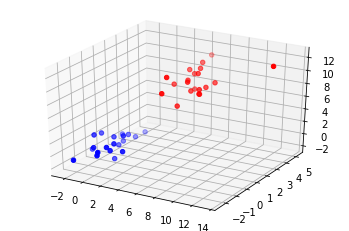

In [136]:
T = mrob.SE3(np.zeros(6))
X_trans = T.transform_array(X.T).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_trans[:,0], X_trans[:,1], X_trans[:,2], marker='o', c='b')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], marker='o', c='r')

In [137]:
def CalcAlErr(T):
  C = 0
  X_trans = T.transform_array(X.T).T
  for i in range(Y[:,0].size):
    C += np.dot((X_trans[i,:]-Y[i,:]).T, np.dot(np.linalg.inv(S[i,:,:]), (X_trans[i,:]-Y[i,:])))
  return C


C = CalcAlErr(T)
print(C)


21989524.467590913


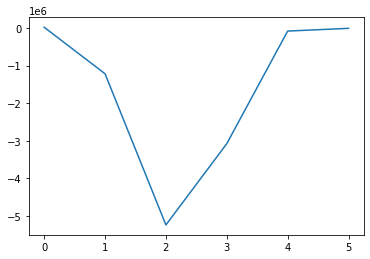

In [154]:
def Grad(T):
  grad = np.zeros(6)
  X_trans = T.transform_array(X.T).T
  for i in range(Y[:,0].size):
    r = X_trans[i,:]-Y[i,:]
    rot = skew(T.transform(X[i]))
    grad_i = np.hstack( (-rot , np.eye(3))) 
    grad += np.dot(r.T, np.dot(np.linalg.inv(S[i,:,:]), grad_i))
  return grad

T_check = mrob.SE3(np.zeros(6))
grad = Grad(T_check)
plt.plot(grad)

In [0]:
def Update_T(grad, alpha):
  T.update_lhs(-alpha * grad)

In [0]:
T = mrob.SE3(np.zeros(6))
alpha = 1e-7*np.hstack((0.1*np.ones(3),np.ones(3)))
errors = []
error = 1
i = 0
while abs(error)>1e-4:
  grad = Grad(T);
  Update_T(grad, alpha)
  curr = CalcAlErr(T)
  if i > 0:
    error = curr - prev
    errors.append(error)
  # if i == 100000:
  #   break
  prev = curr
  i +=1


-9.999937444149509e-05 < 1e-4


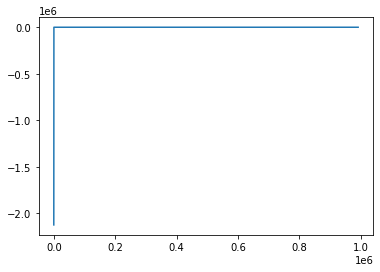

In [167]:
print(errors[len(errors)-1], "< 1e-4")
plt.plot(errors)

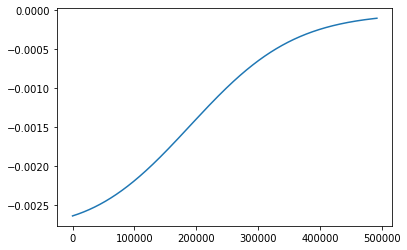

In [162]:
plt.plot(errors[500000:])

Alignment error = 90.02972463539723
Number of needed iterations = 991820


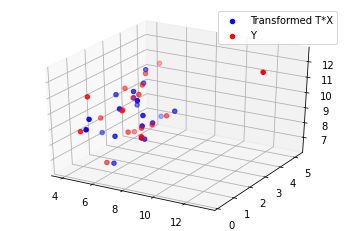

In [165]:
X_trans = T.transform_array(X.T).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_trans[:,0], X_trans[:,1], X_trans[:,2], marker='o', c='b', label='Transformed T*X')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], marker='o', c='r', label='Y')
ax.legend()
error = CalcAlErr(T)
print("Alignment error =", error)
print("Number of needed iterations =", i)

### **Convergence was unstable at the proposed alpha values α = 10^(−6)*[0.1, 0.1, 0.1, 1, 1, 1] so I decresed it 10 times. And with this alpha convergence ( the alignment error difference < 1e-4) occurs after 991820 iterations, which is very time consuming**

In [0]:
def Hess_func(T):
  grad = np.zeros(6)
  Hess = np.zeros((6, 6))
  X_trans = T.transform_array(X.T).T
  for i in range(Y[:,0].size):
    r = X_trans[i,:]-Y[i,:]
    rot = skew(T.transform(X[i]))
    grad_i = np.hstack( (-rot , np.eye(3))) 
    grad += np.dot(r.T, np.dot(np.linalg.inv(S[i,:,:]), grad_i))
    Hess += np.dot(grad_i.T, np.dot(np.linalg.inv(S[i,:,:]), grad_i))
 
  return grad, Hess

In [0]:
def Update_T_New(T, alpha, grad, Hess):
  T.update_lhs(-alpha * np.dot(np.linalg.inv(Hess), grad))

dif of error = -2.3928434700337675e-07
Number of steps = 5
Error = 43.9237386661497


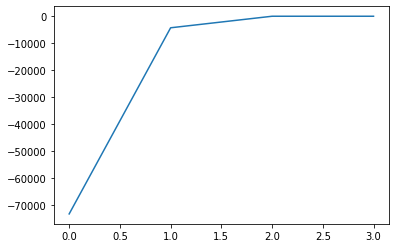

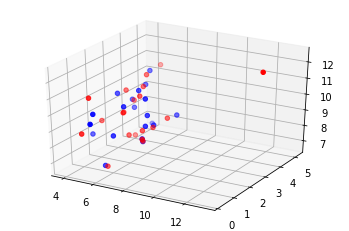

In [151]:
T1 = mrob.SE3(np.zeros(6))
alpha = 1
errors = []
error = 1
i = 0
while(abs(error) > 1e-4):
  grad, Hess = Hess_func(T1)
  Update_T_New(T1, alpha, grad, Hess)
  curr = CalcAlErr(T1)
  if i > 0:
    error = curr - prev
    errors.append(error)
  prev = curr
  i += 1
print("dif of error =", error)
print("Number of steps =", i)
print("Error =", CalcAlErr(T1))

plt.plot(errors)

X_trans = T1.transform_array(X.T).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_trans[:,0], X_trans[:,1], X_trans[:,2], marker='o', c='b')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], marker='o', c='r')

### **Using Gauss-Newton method convergence ( the alignment error difference < 1e-4) occurs after 5 iterations - more faster then the Gradient Descent**